# Clustering particles

In [1]:
# Libraries ----
import sys  # type: ignore
import imageio  # type: ignore
import warnings
import numpy as np  # type: ignore
import pandas as pd  # type: ignore

from tqdm import tqdm  # type: ignore

sys.path.append('../modules')
import track_particles as tp  # type: ignore
import plot_tracking as plt_tp  # type: ignore
import plot_clustering as plt_cp  # type: ignore
import clustering_particles as cp  # type: ignore

# Global options ----
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

## Global variables

In [2]:
input_path = "../input_files"
output_path = "../output_files"
log_path = "../logs"
input_generation_date = "2025-02-18"

video_name = "4n_0m_4f_230330_1"
n_particles = int(video_name[0])
save_figures = True
save_tracking = True
x_bounds = [0, 1080]
y_bounds = [140, 1830]
x_zoom = [0, 1080]
y_zoom = [0, 1920]

## Setting video information

In [3]:
# Load the video
reader = imageio.get_reader("{}/{}.mp4".format(input_path, video_name), "ffmpeg")

# Check the number of frames
num_frames = reader.count_frames()
print("Total frames: {}".format(num_frames))

# Extract a frame to inspect the content
time = 0
frame = reader.get_data(time)
print("Frames resolution: {} x {}".format(frame.shape[0], frame.shape[1]))

Total frames: 25203
Frames resolution: 1080 x 1920


In [4]:
df_tracked = pd.concat([
    pd.read_csv("{}/tracked_{}_0.csv".format(output_path, video_name), low_memory=False)#,
    # pd.read_csv("{}/tracked_{}_1.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_2.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_3.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_4.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_5.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_6.csv".format(output_path, video_name), low_memory=False),
    #pd.read_csv("{}/tracked_{}_7.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_8.csv".format(output_path, video_name), low_memory=False)
]).sort_values(["id", "time"])

In [5]:
if "coords_x" in df_tracked.columns:
    df_tracked["coords_x"] = df_tracked["coords_x"].apply(lambda x: np.fromstring(x, sep=" "))
    df_tracked["coords_y"] = df_tracked["coords_y"].apply(lambda x: np.fromstring(x, sep=" "))
df_tracked.sort_values(["time", "id"]).head(2 * n_particles)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count
0,0,0,215.262267,13.214236,216.893209,13.466910,0.0,249.000000,0.000000,0.364706,155.000000,1.000000,1.515692,2894.0,154.147519,33.759136,0.975724,5
1,1,0,174.127665,195.135174,181.819422,193.256795,0.0,254.000000,134.000000,0.478431,244.000000,184.000000,-1.144628,8256.0,245.783258,89.013272,0.932115,5
2,2,0,751.374107,245.176755,735.602316,251.633456,NaN,751.374107,245.176755,NaN,751.374107,245.176755,-1.381955,9516.0,227.988192,89.631381,0.919478,5
3,3,0,1496.073540,953.368453,1488.319254,955.058852,NaN,1496.073540,953.368453,NaN,1496.073540,953.368453,-1.500249,6663.0,152.773965,71.797058,0.882690,5
4,4,0,1249.070796,972.525014,1247.666709,970.220410,NaN,1249.070796,972.525014,NaN,1249.070796,972.525014,-1.055800,5537.0,138.705979,84.502996,0.792998,5
5,0,3,215.859966,13.459625,217.475424,13.714551,0.0,249.000000,0.000000,0.364706,154.000000,1.000000,1.510070,2935.0,153.497499,34.122380,0.974978,5
6,1,3,173.917082,195.045714,181.340643,193.106572,0.0,252.000000,134.000000,0.478431,206.000000,184.000000,-1.142935,8225.0,246.147451,89.045284,0.932273,5
7,2,3,743.392808,243.966108,728.629673,249.212533,NaN,743.392808,243.966108,NaN,743.392808,243.966108,-1.463909,8704.0,238.483316,90.563028,0.925091,5


In [6]:
# Manual Setup for time = 0
tracking_0 = df_tracked[df_tracked["time"] == 0]
cols = ["id", "time", "id_count", "position_x", "position_y", "orientation"]
print("Initial tracking at time 0:\n", tracking_0[cols])

if tracking_0.shape[0] != n_particles:
    # Manual fitting of initial time tracking
    tracking_0 = tracking_0.drop_duplicates(subset=["id"], keep="first")
    tracking_0 = tracking_0[tracking_0["id"].isin([1, 2, 3, 4])]
    tracking_0["id"] = np.arange(n_particles)
    tracking_0["orientation"] = np.array([
        -tracking_0["orientation"].values[0],
        tracking_0["orientation"].values[1],
        tracking_0["orientation"].values[2],
        -tracking_0["orientation"].values[3]
    ])

    # Replace the manual setting
    df_tracked = pd.concat([
        tracking_0,
        df_tracked[df_tracked["time"] != 0]
    ]).sort_values(["id", "time"])

df_tracked.sort_values(["time", "id"]).head(2 * n_particles + 1)

Initial tracking at time 0:
    id  time  id_count   position_x  position_y  orientation
0   0     0         5   215.262267   13.214236     1.515692
1   1     0         5   174.127665  195.135174    -1.144628
2   2     0         5   751.374107  245.176755    -1.381955
3   3     0         5  1496.073540  953.368453    -1.500249
4   4     0         5  1249.070796  972.525014    -1.055800


,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count
1,0,0,174.127665,195.135174,181.819422,193.256795,0.0,254.000000,134.000000,0.478431,244.000000,184.000000,1.144628,8256.0,245.783258,89.013272,0.932115,5
2,1,0,751.374107,245.176755,735.602316,251.633456,NaN,751.374107,245.176755,NaN,751.374107,245.176755,-1.381955,9516.0,227.988192,89.631381,0.919478,5
3,2,0,1496.073540,953.368453,1488.319254,955.058852,NaN,1496.073540,953.368453,NaN,1496.073540,953.368453,-1.500249,6663.0,152.773965,71.797058,0.882690,5
4,3,0,1249.070796,972.525014,1247.666709,970.220410,NaN,1249.070796,972.525014,NaN,1249.070796,972.525014,1.055800,5537.0,138.705979,84.502996,0.792998,5
5,0,3,215.859966,13.459625,217.475424,13.714551,0.0,249.000000,0.000000,0.364706,154.000000,1.000000,1.510070,2935.0,153.497499,34.122380,0.974978,5
6,1,3,173.917082,195.045714,181.340643,193.106572,0.0,252.000000,134.000000,0.478431,206.000000,184.000000,-1.142935,8225.0,246.147451,89.045284,0.932273,5
7,2,3,743.392808,243.966108,728.629673,249.212533,NaN,743.392808,243.966108,NaN,743.392808,243.966108,-1.463909,8704.0,238.483316,90.563028,0.925091,5
8,3,3,1496.676497,953.130891,1489.740482,954.374100,NaN,1496.676497,953.130891,NaN,1496.676497,953.130891,-1.507849,6578.0,151.736459,71.177751,0.883151,5
9,4,3,1251.790483,972.611469,1252.209892,970.981434,NaN,1251.790483,972.611469,NaN,1251.790483,972.611469,-1.139856,5737.0,144.777088,87.523802,0.796573,5


In [7]:
df_tracked.sort_values(["time", "id"]).tail(5)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count
35756,0,25197,116.500498,247.961320,131.590963,264.163580,NaN,116.500498,247.961320,NaN,116.500498,247.961320,-0.065919,23087.0,438.322913,222.957815,0.860967,2
35757,1,25197,1556.648520,913.026930,1555.266297,902.185009,0.0,1580.000000,798.000000,0.592157,1559.000000,884.000000,-0.303747,8615.0,234.987077,66.519681,0.959097,2
35758,0,25200,963.477505,5.299591,963.539308,5.297761,0.0,919.000000,1.000000,0.474510,919.000000,0.000000,-1.568290,978.0,99.796091,14.386699,0.989554,3
35759,1,25200,116.519915,247.951406,131.601353,263.945712,NaN,116.519915,247.951406,NaN,116.519915,247.951406,-0.066588,23048.0,437.998806,223.014460,0.860668,3
35760,2,25200,1556.632532,913.029723,1555.238720,902.228899,0.0,1580.000000,798.000000,0.596078,1552.000000,884.000000,-0.303622,8613.0,234.803115,66.527407,0.959022,3


## Velocities distribution in each frame

In [8]:
omega_threshold = np.pi / 2 # Angular velocity per frame
velocity_threshold = 94.0 # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi)

# Compute differences for each id
df_tracked["delta_time"] = df_tracked.groupby(["id"])["time"].diff()
df_tracked["velocity_x"] = df_tracked.groupby(["id"])["position_x"].diff()
df_tracked["velocity_y"] = df_tracked.groupby(["id"])["position_y"].diff()
df_tracked["velocity_orientation"] = df_tracked.groupby(["id"])["orientation"].diff()

# Compute velocity components (change in position divided by change in time)
df_tracked["velocity_x"] = df_tracked["velocity_x"] / df_tracked["delta_time"]
df_tracked["velocity_y"] = df_tracked["velocity_y"] / df_tracked["delta_time"]
df_tracked["velocity_orientation"] = df_tracked["velocity_orientation"] / df_tracked["delta_time"]

# Filter short jumps (highest velocities are False)
df_tracked["mask_x"] = np.where(np.abs(df_tracked["velocity_x"]) <= velocity_threshold, True, False)
df_tracked["mask_y"] = np.where(np.abs(df_tracked["velocity_y"]) <= velocity_threshold, True, False)
df_tracked["mask_orientation"] = np.where(np.abs(df_tracked["velocity_orientation"]) <= omega_threshold, True, False)


Thresholds:
	- Velocity: 94.0 
	- Angle: 90.0


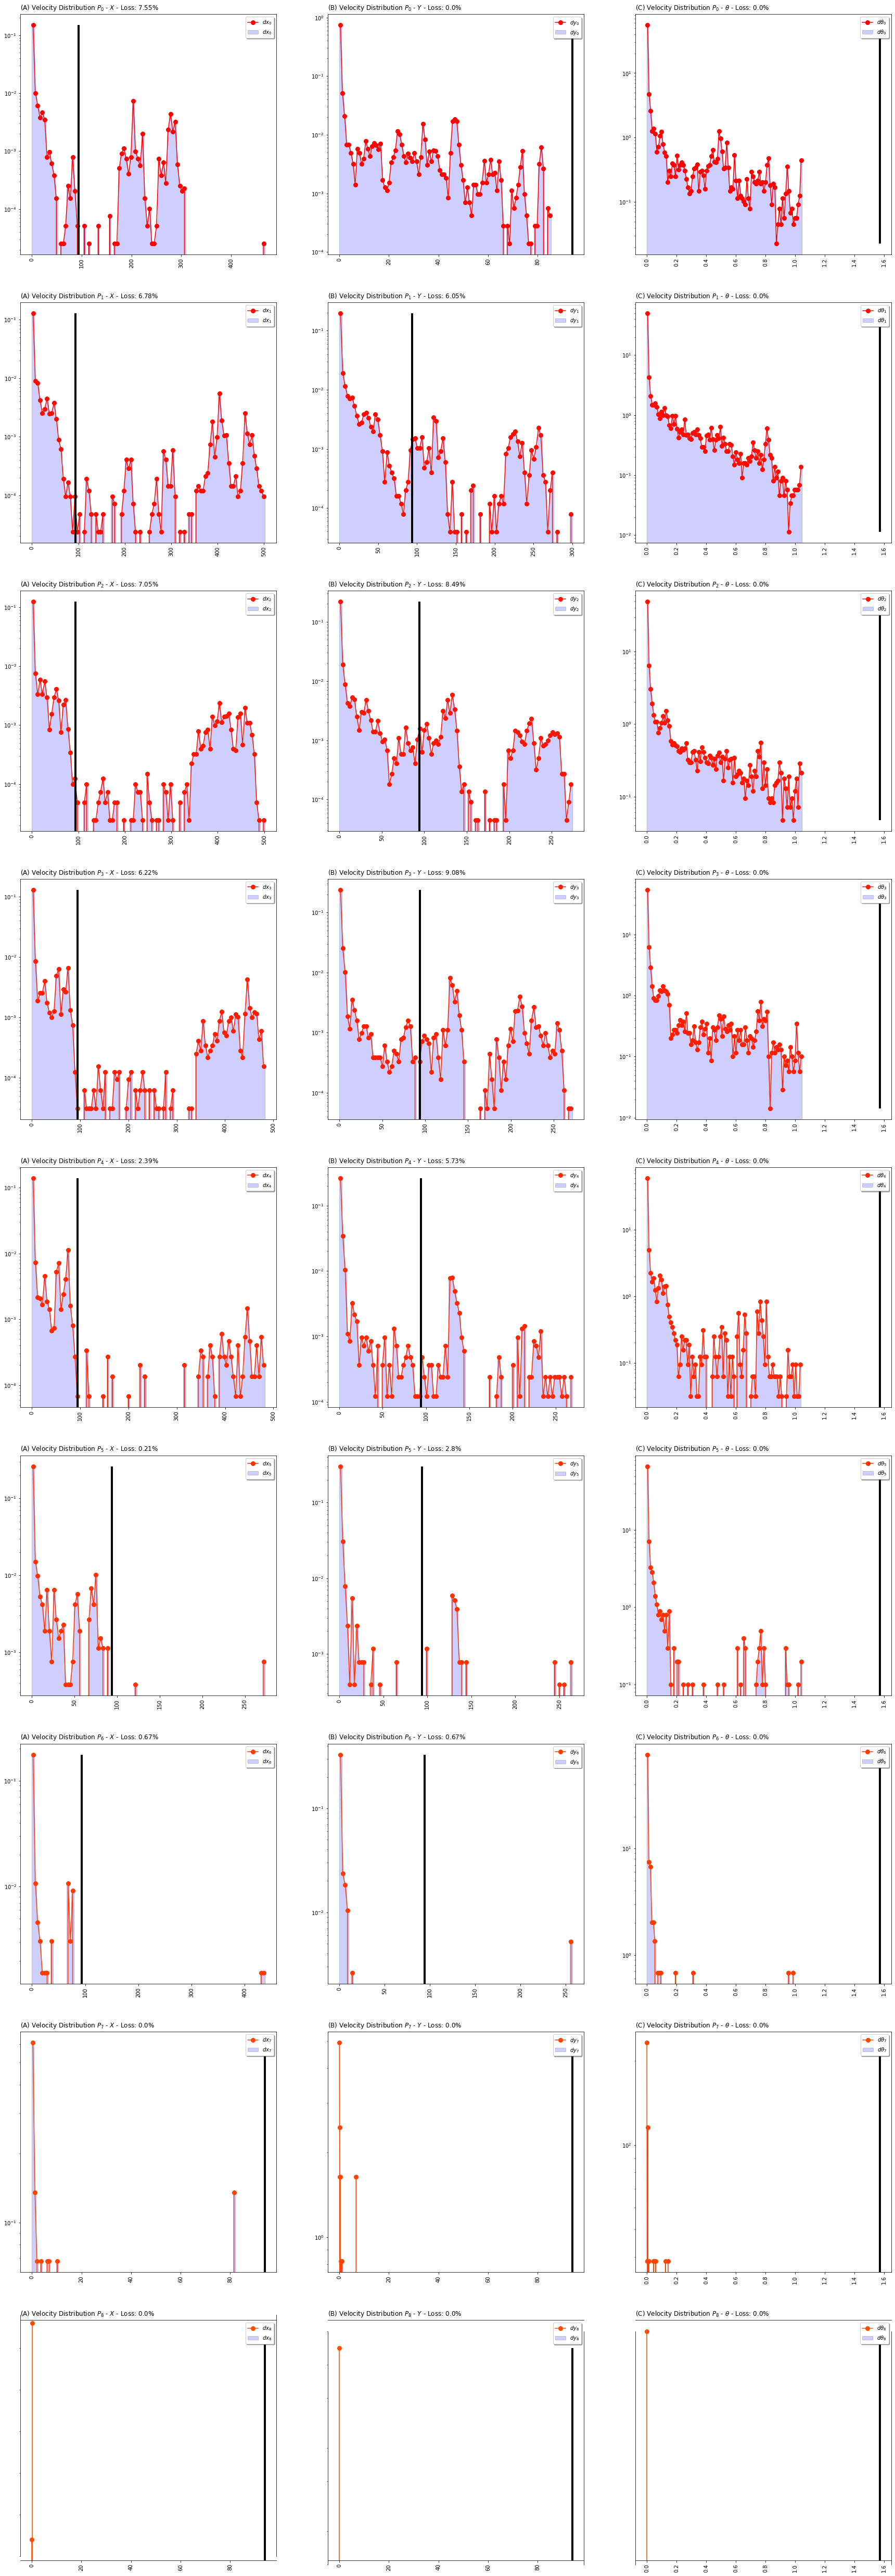

In [9]:
bins = 100
width = 10
fancy_legend = True

plt_cp.plot_velocities_distribution(
    df_tracked=df_tracked,
    bins=bins,
    velocity_threshold=velocity_threshold,
    omega_threshold=omega_threshold,
    width=width,
    fancy_legend=fancy_legend
)

In [10]:
df_tracked[["id_count"]].value_counts(dropna=False, sort=False, normalize=False).reset_index().sort_values("id_count")

,id_count,count
0,2,664
1,3,4224
2,4,14280
3,5,10624
4,6,4896
5,7,917
6,8,128
7,9,27


## Clustering frames

In [11]:
# id_count = df_tracked["id_count"].max()
type = "local equalized"
clip_limit = 0.05
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = 100 # Velocity per frame limited with half average size of particle
compare_bounds = False
similarity_threshold = 0.85

print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")
# ids = df_tracked[df_tracked["id_count"] != n_particles]["id_count"].unique()
# ids = sorted(np.sort(ids), key=lambda n: abs(n - n_particles))

df_clustered = cp.clustering_local_frames(
    reader=reader,
    df_tracked=df_tracked,
    weights_previous_time=[0],
    type=type,
    clip_limit=clip_limit,
    distance_threshold=velocity_threshold,
    compare_bounds=compare_bounds,
    similarity_threshold=similarity_threshold,
    n_particles=n_particles
)

Thresholds:
	- Velocity: 100 
	- Angle: 45.18231031331892 



In [12]:
df_clustered["id_count_new"] = df_clustered.groupby(["time"])["id"].transform("count")  # noqa: 501

### Explore final data

In [13]:
df_counts = (
    df_tracked[["id_count", "mask_x", "mask_y", "mask_orientation"]]
    .value_counts(dropna=False, sort=False, normalize=True)
    .reset_index()
    .sort_values(["id_count", "mask_x", "mask_y", "mask_orientation"])
)
df_counts["proportion"] = 100 * df_counts["proportion"]
df_counts

,id_count,mask_x,mask_y,mask_orientation,proportion
0,2,False,False,False,1.476510
1,2,False,True,False,0.047539
2,2,True,True,False,0.332774
3,3,False,False,False,10.128635
4,3,False,True,False,0.447427
5,3,True,False,False,0.296421
6,3,True,True,False,0.939597
7,4,False,False,False,36.691834
8,4,False,True,False,0.894855
9,4,True,False,False,0.892058


In [14]:
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = df_tracked["velocity_x"].abs().quantile(0.815) # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")

# Compute differences for each id
df_clustered["delta_time"] = df_clustered.groupby(["id"])["time"].diff()
df_clustered["velocity_x"] = df_clustered.groupby(["id"])["position_x"].diff()
df_clustered["velocity_y"] = df_clustered.groupby(["id"])["position_y"].diff()
df_clustered["velocity_orientation"] = df_clustered.groupby(["id"])["orientation"].diff()

# Compute velocity components (change in position divided by change in time)
df_clustered["velocity_x"] = df_clustered["velocity_x"] / df_clustered["delta_time"]
df_clustered["velocity_y"] = df_clustered["velocity_y"] / df_clustered["delta_time"]
df_clustered["velocity_orientation"] = df_clustered["velocity_orientation"] / df_clustered["delta_time"]

# Filter short jumps (highest velocities are False)
df_clustered["mask_x"] = np.where(np.abs(df_clustered["velocity_x"]) <= velocity_threshold, True, False)
df_clustered["mask_y"] = np.where(np.abs(df_clustered["velocity_y"]) <= velocity_threshold, True, False)
df_clustered["mask_orientation"] = np.where(np.abs(df_clustered["velocity_orientation"]) <= omega_threshold, True, False)


Thresholds:
	- Velocity: 51.483995295100975 
	- Angle: 45.18231031331892 



In [15]:
df_counts = (
    df_clustered[["id_count_new", "mask_x", "mask_y", "mask_orientation"]]
    .value_counts(dropna=False, sort=False, normalize=True)
    .reset_index()
    .sort_values(["id_count_new", "mask_x", "mask_y", "mask_orientation"])
)
df_counts["proportion"] = 100 * df_counts["proportion"]

print("Final loss data : {}%".format(df_counts[df_counts["id_count_new"]!=n_particles]["proportion"].sum()))
print("Final loss data X-axis: {}%".format(df_counts[df_counts["mask_x"]==False]["proportion"].sum()))
print("Final loss data Y-axis: {}%".format(df_counts[df_counts["mask_y"]==False]["proportion"].sum()))
print("Final loss data Angle : {}%".format(df_counts[df_counts["mask_orientation"]==False]["proportion"].sum()))
df_counts

Final loss data : 0.0%
Final loss data X-axis: 3.6424235210094036%
Final loss data Y-axis: 2.3657897869301276%
Final loss data Angle : 1.8866801571241518%


,id_count_new,mask_x,mask_y,mask_orientation,proportion
0,4,False,False,False,0.246994
1,4,False,False,True,1.809308
2,4,False,True,False,0.139864
3,4,False,True,True,1.446256
4,4,True,False,False,0.059517
5,4,True,False,True,0.249970
6,4,True,True,False,1.440305
7,4,True,True,True,94.607785


In [16]:
df_filter_clustered = df_clustered[df_clustered["id_count_new"] == n_particles]
df_filter_clustered["id_count"] = df_filter_clustered["id_count_new"]
df_filter_clustered = df_filter_clustered.drop(columns=["id_count_new"])

Thresholds:
	- Velocity: 51.483995295100975 
	- Angle: 45.18231031331892 



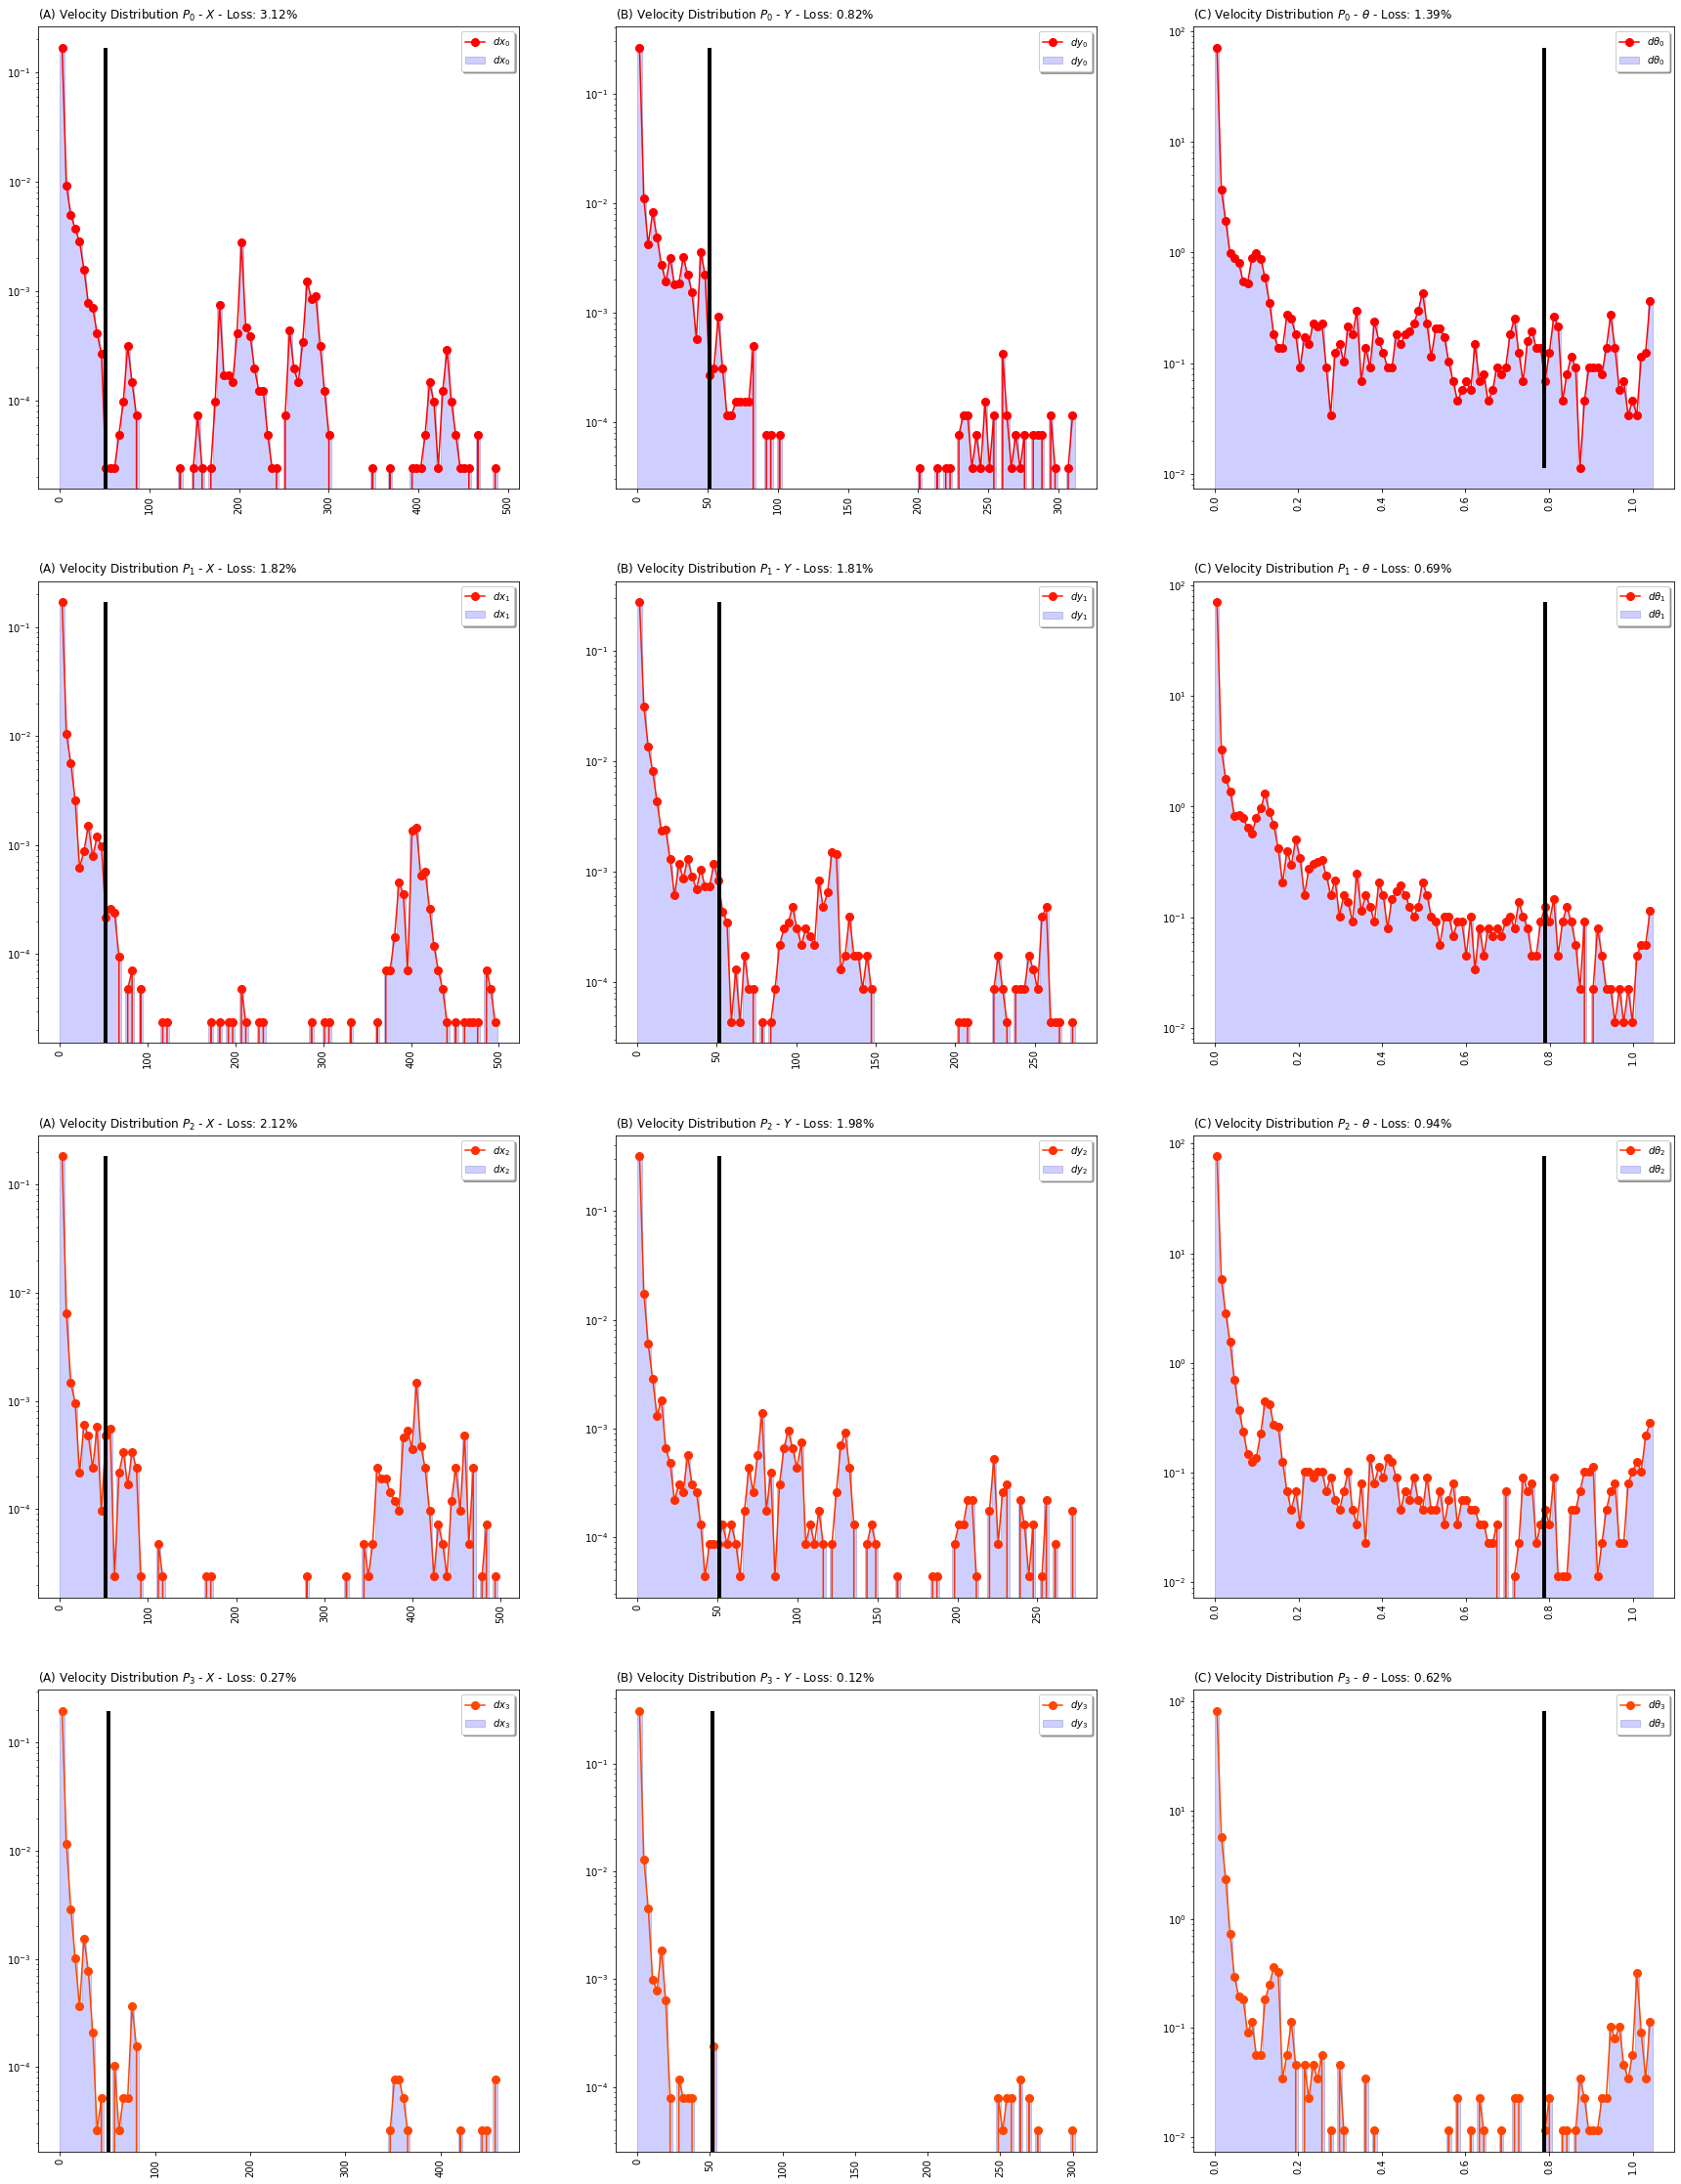

In [17]:
bins = 100
width = 10
fancy_legend = True
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = df_tracked["velocity_x"].abs().quantile(0.815) # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")

plt_cp.plot_velocities_distribution(
    df_tracked=df_filter_clustered,
    bins=bins,
    velocity_threshold=velocity_threshold,
    omega_threshold=omega_threshold,
    width=width,
    fancy_legend=fancy_legend
)

In [18]:
if "coords_x" in df_filter_clustered.columns:
    df_filter_clustered.drop(columns=["coords_x", "coords_y"]).to_csv("{}/clustered_{}.csv".format(output_path, video_name), index=False)
else:
    df_filter_clustered.to_csv("{}/clustered_{}.csv".format(output_path, video_name), index=False)

In [19]:
df_filter_clustered.head(n_particles * 3)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count,delta_time,velocity_x,velocity_y,velocity_orientation,mask_x,mask_y,mask_orientation
0,0,0,174.127665,195.135174,181.819422,193.256795,0.0,254.000000,134.000000,0.478431,244.000000,184.000000,1.144628,8256.0,245.783258,89.013272,0.932115,4,NaN,NaN,NaN,NaN,False,False,False
3571,1,0,751.374107,245.176755,735.602316,251.633456,NaN,751.374107,245.176755,NaN,751.374107,245.176755,-1.381955,9516.0,227.988192,89.631381,0.919478,4,NaN,NaN,NaN,NaN,False,False,False
7142,2,0,1496.073540,953.368453,1488.319254,955.058852,NaN,1496.073540,953.368453,NaN,1496.073540,953.368453,-1.500249,6663.0,152.773965,71.797058,0.882690,4,NaN,NaN,NaN,NaN,False,False,False
10713,3,0,1249.070796,972.525014,1247.666709,970.220410,NaN,1249.070796,972.525014,NaN,1249.070796,972.525014,1.055800,5537.0,138.705979,84.502996,0.792998,4,NaN,NaN,NaN,NaN,False,False,False
14284,0,3,173.917082,195.045714,181.340643,193.106572,0.0,252.000000,134.000000,0.478431,206.000000,184.000000,-1.142935,8225.0,246.147451,89.045284,0.932273,4,3.0,-0.070194,-0.029820,-0.762521,False,False,False
14285,1,3,743.392808,243.966108,728.629673,249.212533,NaN,743.392808,243.966108,NaN,743.392808,243.966108,-1.463909,8704.0,238.483316,90.563028,0.925091,4,3.0,-2.660433,-0.403549,-0.027318,False,False,False
14286,2,3,1496.676497,953.130891,1489.740482,954.374100,NaN,1496.676497,953.130891,NaN,1496.676497,953.130891,-1.507849,6578.0,151.736459,71.177751,0.883151,4,3.0,0.200986,-0.079187,-0.002533,False,False,False
14287,3,3,1251.790483,972.611469,1252.209892,970.981434,NaN,1251.790483,972.611469,NaN,1251.790483,972.611469,-1.139856,5737.0,144.777088,87.523802,0.796573,4,3.0,0.906562,0.028819,-0.731885,False,False,False
14288,0,6,174.115684,194.996834,181.699060,192.960370,0.0,252.000000,134.000000,0.478431,242.000000,184.000000,-1.143013,8212.0,245.987018,88.769268,0.932616,4,3.0,0.066201,-0.016293,-0.000026,False,False,False
14289,1,6,722.948120,249.939767,707.300358,253.310114,NaN,722.948120,249.939767,NaN,722.948120,249.939767,1.548805,9098.0,239.369006,89.996023,0.926631,4,3.0,-6.814896,1.991220,1.004238,False,False,True


## Visualize final data

In [20]:
width = 10
n_x_breaks = 20
n_y_breaks = 20
x_bounds = x_bounds  # Range: [0, 1080]
y_bounds = y_bounds  # Range: [0, 1920]
x_zoom = None  # x_zoom
y_zoom = None  # y_zoom
fancy_legend = True
x_legend = 1.001
y_legend = 0.821

if save_figures:
    df_data = df_filter_clustered[["time", "id_count", "id"]].drop_duplicates()
    df_data["id_included"] = True
    df_data["orientation_included"] = True

    # for time in tqdm(df_filter_clustered["time"].unique()):
    for time in tqdm([0, 10, 20, 50, 100]):
        plt_tp.plot_tracking_frame(
            reader=reader,
            df_tracked_frame=df_filter_clustered,
            width=width,
            n_x_breaks=n_x_breaks,
            n_y_breaks=n_y_breaks,
            x_bounds=x_bounds,
            y_bounds=y_bounds,
            x_zoom=x_zoom,
            y_zoom=y_zoom,
            fancy_legend=fancy_legend,
            x_legend=x_legend,
            y_legend=y_legend,
            save_figure=True,
            output_path=output_path,
            output_name="{}_c".format(video_name),
            time=time
        )

    df_data.to_csv("{}/{}_c/df_control.csv".format(output_path, video_name), index=False)


100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


In [21]:
from shutil import make_archive

make_archive(
    "{}/{}_c".format(output_path, video_name),
    "zip",
    output_path,
    "{}/{}_c".format(output_path, video_name)
)

'/home/fabril/Github/High_Order_Interactions/tracking_videos/output_files/4n_0m_4f_230330_1_c.zip'